In [38]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import csv
from skimage import measure
from skimage.transform import resize
import progressbar
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

In [2]:
DATA_DIR = '../pneumonia_data'

# Directory to save logs and trained model
ROOT_DIR = './logdir'
IMAGE_DIR = '../pneumonia_data/train_images'

In [3]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(DATA_DIR + '/stage_1_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [4]:
# load and shuffle filenames

filenames = os.listdir(IMAGE_DIR)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23124
n valid samples 2560


Total train images: 25684
Images with pneumonia: 5659


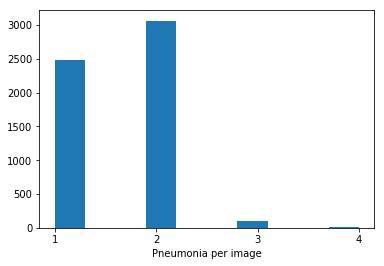

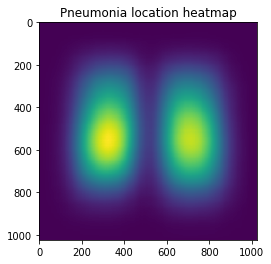

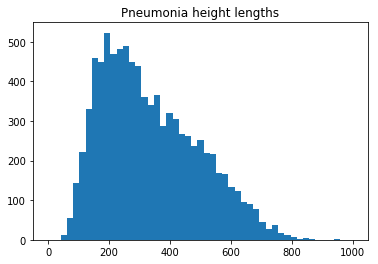

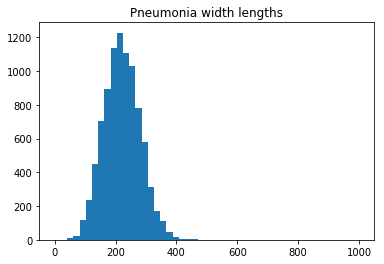

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [5]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

In [6]:
class generator(object):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False,predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.45
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [35]:
mygen = generator(IMAGE_DIR, train_filenames, pneumonia_locations = pneumonia_locations)
#Build a model on the data
def generate_rf(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=2, min_samples_leaf=3)
    rf.fit(X_train, y_train)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a
# read in the previously written training file in chunks



As we do not have keras and tf we will be working with a multi output RF. Sounds silly? You might be right

In [ ]:
#max_depth = 30
#regr_multirf = MultiOutputRegressor (RandomForestRegressor(max_depth=max_depth, random_state=0, warm_start = True))
rfs = []
imsize = mygen.image_size
w = 10
patch_size = 2*w+1
num_args = patch_size * patch_size
chunk_size = 50000
# train the model
X_train = []
Y_train = []
numproc = 0
bar = progressbar.ProgressBar(maxval=len(train_filenames), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()


for batch in range(len(mygen)):
    #print('Processing Batch '+str(batch)+' of '+str(len(mygen)))
    imgs, masks = mygen[batch]
    for imnum in range(imgs.shape[0]):
        numproc += 1
        img = np.squeeze(imgs[imnum])
        msk = np.squeeze(masks[imnum])
        for i in range(imsize):
            for j in range(imsize):
                patch = np.zeros((patch_size, patch_size),dtype = np.float32)
                rlower = max(0,i-w)
                if rlower > i-w:
                    rloffset = w-i
                else:
                    rloffset = 0
                rhigher = min(imsize,i+w+1)
                rhoffset = rhigher-rlower
                clower = max(0,j-w)
                if clower > j-w:
                    cloffset = w-j
                else:
                    cloffset = 0
                chigher = min(imsize,j+w+1)
                choffset = chigher-clower
                target = msk[i,j]
                #print(rlower)
                #print(rhigher)
                #print(clower)
                #print(chigher)
                #print(i)
                #print(j)
                # this is meant to take a patch of size 2*w+1 from the input image
                patch[rloffset:(rloffset+rhoffset),cloffset:(cloffset+choffset)] = img[rlower:rhigher,clower:chigher]
                X_train.append(patch.flatten())
                Y_train.append(target)
                if len(Y_train) > chunk_size:
                    bar.update(numproc)
                    rfs.append(generate_rf(X_train,Y_train))
                    X_train = []
                    Y_train = []
                # TODO add metadata from the image tags to the file
rf_combined = reduce(combine_rfs, rfs)
pickle.dump(rf_combined, open('rf_combined.sklearn','wb'))
bar.finish()

In [ ]:

# test the model
validator = generator(IMAGE_DIR, valid_filenames, pneumonia_locations = pneumonia_locations)